# Credit Risk Resampling Techniques

In [98]:
import warnings
warnings.filterwarnings('ignore')

In [99]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [100]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
#from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import ClusterCentroids
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# Read the CSV into DataFrame

In [101]:
# Load the data
file_path = Path('Resources/lending_data.csv')
df = pd.read_csv(file_path)
df.head()

,loan_size,interest_rate,homeowner,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
0,10700.0,7.672,own,52800,0.431818,5,1,22800,low_risk
1,8400.0,6.692,own,43600,0.311927,3,0,13600,low_risk
2,9000.0,6.963,rent,46100,0.349241,3,0,16100,low_risk
3,10700.0,7.664,own,52700,0.430740,5,1,22700,low_risk
4,10800.0,7.698,mortgage,53000,0.433962,5,1,23000,low_risk


### Data discovery

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77536 entries, 0 to 77535
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   loan_size         77536 non-null  float64
 1   interest_rate     77536 non-null  float64
 2   homeowner         77536 non-null  object 
 3   borrower_income   77536 non-null  int64  
 4   debt_to_income    77536 non-null  float64
 5   num_of_accounts   77536 non-null  int64  
 6   derogatory_marks  77536 non-null  int64  
 7   total_debt        77536 non-null  int64  
 8   loan_status       77536 non-null  object 
dtypes: float64(3), int64(4), object(2)
memory usage: 5.3+ MB


***The data has no null values. A couple of columns need attention since they are an object datatype. Should convert them to int.***

In [103]:
df["loan_status"].value_counts()

low_risk     75036
high_risk     2500
Name: loan_status, dtype: int64

In [104]:
df["homeowner"].value_counts()

mortgage    38572
own         30930
rent         8034
Name: homeowner, dtype: int64

In [105]:
df.describe()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt
count,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000
mean,9805.562577,7.292333,49221.949804,0.377318,3.826610,0.392308,19221.949804
std,2093.223153,0.889495,8371.635077,0.081519,1.904426,0.582086,8371.635077
min,5000.000000,5.250000,30000.000000,0.000000,0.000000,0.000000,0.000000
25%,8700.000000,6.825000,44800.000000,0.330357,3.000000,0.000000,14800.000000
50%,9500.000000,7.172000,48100.000000,0.376299,4.000000,0.000000,18100.000000
75%,10400.000000,7.528000,51400.000000,0.416342,4.000000,1.000000,21400.000000
max,23800.000000,13.235000,105200.000000,0.714829,16.000000,3.000000,75200.000000


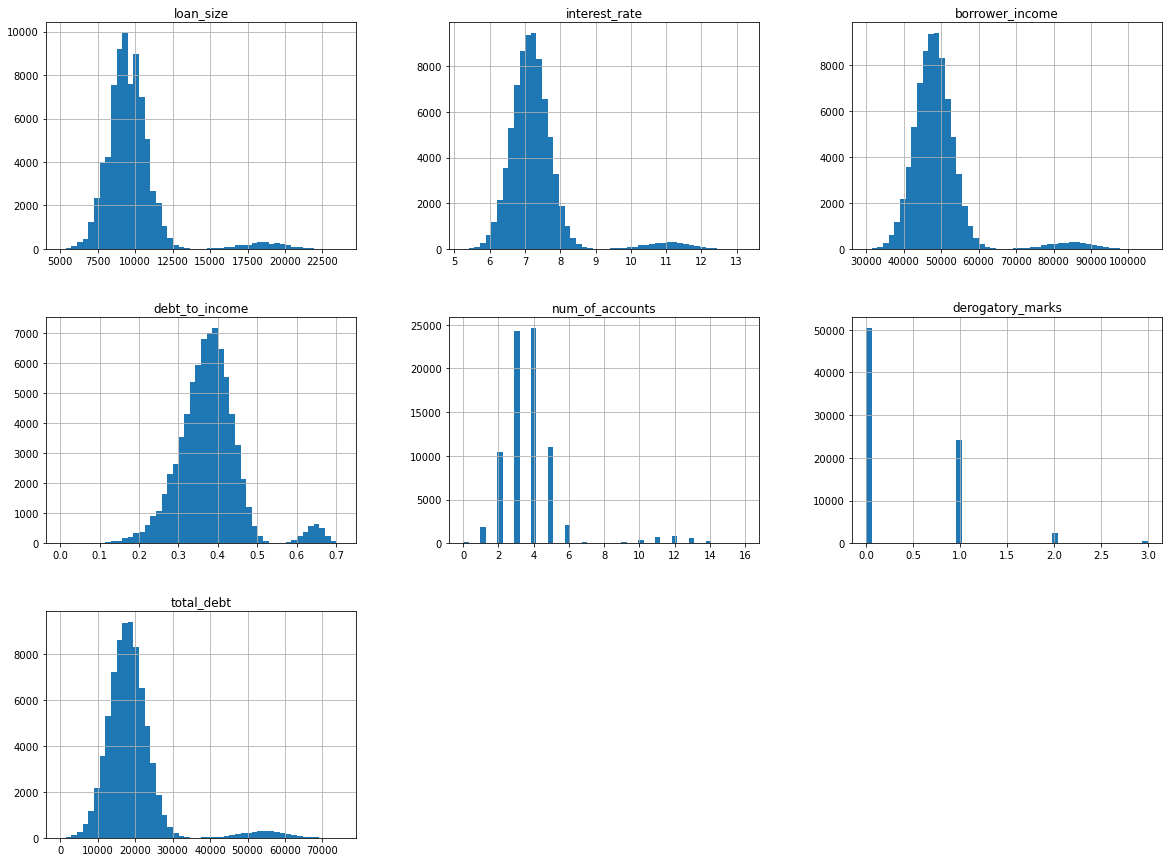

In [106]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

# Split the Data into Training and Testing

In [107]:
# Create our features
X = df.drop(columns="loan_status")
X = pd.get_dummies(X)

# Create our target
y = df["loan_status"].to_frame()

In [108]:
X.describe()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,homeowner_mortgage,homeowner_own,homeowner_rent
count,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000
mean,9805.562577,7.292333,49221.949804,0.377318,3.826610,0.392308,19221.949804,0.497472,0.398911,0.103616
std,2093.223153,0.889495,8371.635077,0.081519,1.904426,0.582086,8371.635077,0.499997,0.489678,0.304764
min,5000.000000,5.250000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8700.000000,6.825000,44800.000000,0.330357,3.000000,0.000000,14800.000000,0.000000,0.000000,0.000000
50%,9500.000000,7.172000,48100.000000,0.376299,4.000000,0.000000,18100.000000,0.000000,0.000000,0.000000
75%,10400.000000,7.528000,51400.000000,0.416342,4.000000,1.000000,21400.000000,1.000000,1.000000,0.000000
max,23800.000000,13.235000,105200.000000,0.714829,16.000000,3.000000,75200.000000,1.000000,1.000000,1.000000


In [109]:
# Check the balance of our target values
y["loan_status"].value_counts()

low_risk     75036
high_risk     2500
Name: loan_status, dtype: int64

In [110]:
# Create X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=1)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [111]:
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [112]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train, y_train)

In [113]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Simple Logistic Regression

In [114]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [115]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = model.predict(X_test)
simple_logistic_BA = balanced_accuracy_score(y_test, y_pred)
simple_logistic_BA

0.9520479254722232

In [116]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[  563,    56],
       [  102, 18663]])

In [117]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.85      0.91      0.99      0.88      0.95      0.90       619
   low_risk       1.00      0.99      0.91      1.00      0.95      0.91     18765

avg / total       0.99      0.99      0.91      0.99      0.95      0.91     19384



# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [118]:
# Resample the training data with the RandomOversampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

# View the count of target classes with Counter
Counter(y_resampled)

Counter({'loan_status': 1})

In [119]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [120]:
# Calculated the balanced accuracy score
y_predictions = model.predict(X_test)
native_random_sampling_BA = balanced_accuracy_score(y_test, y_predictions)
native_random_sampling_BA

0.027238478468705918

In [121]:
# Display the confusion matrix
confusion_matrix(y_test, y_predictions)

array([[    4,   615],
       [17864,   901]])

In [122]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_predictions))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.00      0.01      0.05      0.00      0.02      0.00       619
   low_risk       0.59      0.05      0.01      0.09      0.02      0.00     18765

avg / total       0.58      0.05      0.01      0.09      0.02      0.00     19384



### SMOTE Oversampling

In [123]:
# Resample the training data with SMOTE
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy=1.0).fit_resample(
    X_train_scaled, y_train
)

# View the count of target classes with Counter
Counter(y_resampled)

Counter({'loan_status': 1})

In [124]:
# Train the Logistic Regression model using the resampled data
model2 = LogisticRegression(solver='lbfgs', random_state=1)
model2.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [125]:
# Calculated the balanced accuracy score
y_predictions2 = model2.predict(X_test_scaled)
SMOTE_BA = balanced_accuracy_score(y_test, y_predictions2)
SMOTE_BA

0.9934649587814939

In [126]:
# Display the confusion matrix
confusion_matrix(y_test, y_predictions2)

array([[  615,     4],
       [  124, 18641]])

In [127]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_predictions2))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.83      0.99      0.99      0.91      0.99      0.99       619
   low_risk       1.00      0.99      0.99      1.00      0.99      0.99     18765

avg / total       0.99      0.99      0.99      0.99      0.99      0.99     19384



# Undersampling

In this section, you will test an undersampling algorithm to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Display the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [128]:
# Resample the data using the ClusterCentroids resampler
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

# View the count of target classes with Counter
Counter(y_resampled)

Counter({'loan_status': 1})

In [129]:
# Train the Logistic Regression model using the resampled data
model3 = LogisticRegression(solver='lbfgs', random_state=1)
model3.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [130]:
# Calculate the balanced accuracy score
y_predictions3 = model3.predict(X_test)
undersampling_BA = balanced_accuracy_score(y_test, y_predictions3)
undersampling_BA

0.9881304218875842

In [131]:
# Display the confusion matrix
confusion_matrix(y_test, y_predictions3)

array([[  608,    11],
       [  112, 18653]])

In [132]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_predictions3))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.84      0.98      0.99      0.91      0.99      0.98       619
   low_risk       1.00      0.99      0.98      1.00      0.99      0.98     18765

avg / total       0.99      0.99      0.98      0.99      0.99      0.98     19384



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Display the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [133]:
# Resample the training data with SMOTEENN
smote_enn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)


# View the count of target classes with Counter
Counter(y_resampled)

Counter({'loan_status': 1})

In [134]:
# Train the Logistic Regression model using the resampled data
model4 = LogisticRegression(solver='lbfgs', random_state=1)
model4.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [135]:
# Calculate the balanced accuracy score
y_predictions4 = model.predict(X_test_scaled)
SMOTE_ENN_BA = balanced_accuracy_score(y_test, y_predictions4)
SMOTE_ENN_BA

0.9934649587814939

In [136]:
# Display the confusion matrix
confusion_matrix(y_test, y_predictions4)

array([[  615,     4],
       [  124, 18641]])

In [137]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_predictions4))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.83      0.99      0.99      0.91      0.99      0.99       619
   low_risk       1.00      0.99      0.99      1.00      0.99      0.99     18765

avg / total       0.99      0.99      0.99      0.99      0.99      0.99     19384



# Final Questions

1. Which model had the best balanced accuracy score?

   SMOTE and SMOTE_ENN.

2. Which model had the best recall score?

    Aside from Native Random Oversampling, all models have a recall score of 0.99 which is expected as we are overfitting the models (Precision and recall are measures of how well the model performs in terms of the predicted class labels). 

3. Which model had the best geometric mean score?

    SMOTE and SMOTE_ENN.


In [138]:
print(SMOTE_BA, SMOTE_ENN_BA, undersampling_BA, native_random_sampling_BA, simple_logistic_BA)

0.9934649587814939 0.9934649587814939 0.9881304218875842 0.027238478468705918 0.9520479254722232
